# Scrape+Stats Geekbench

PH Feb 2025

In [1]:
import requests
import glob
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time

## Scrape

### Scrape functions

In [2]:
def retrieve_geekbench(search, page=1):
    """returns the html code of Geekbench (v6) browser search
    """
    url = "https://browser.geekbench.com/search"
    
    # Effectuer la requête HTTP
    headers = {'User-Agent': 'Mozilla/5.0'}
    params = {
        'q': search.replace(' ', '+'),
        'page': page
    }
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    html = response.text
    return html

In [3]:
def parse_geekbench_df(gb_html):
    """parse html code of Geekbench (v6) browser search
    into pandas DataFrame
    """
    # Parse HTML
    soup = BeautifulSoup(gb_html, 'html.parser')
    # Search results
    devices = []
    rows = soup.find_all("div", class_="list-col-inner")
    re_ncore = re.compile(r'\((\d+) cores\)') # matches '(12 cores)'
    
    for row in rows:
        # System description
        system_link = row.find("a")
        system_name = system_link.text.strip()
        system_url = "https://browser.geekbench.com" + system_link["href"]
        model_info = row.find("span", class_="list-col-model").text.strip()
        # detail model info:
        cpu_name, cpu_freq, cpu_cores = model_info.split("\n")
        cpu_freq = int(cpu_freq.replace(' MHz', ''))
        cpu_cores = int(re_ncore.match(cpu_cores).group(1))
        
        uploaded = row.find_all("span", class_="list-col-text")[0].text.strip()
        uploaded = uploaded.split('\n')[0] # remove the username which is sometimes here
        
        platform = row.find_all("span", class_="list-col-text")[1].text.strip()
        
        single_core = float(row.find("span", class_="list-col-text-score").text.strip())
        multi_core = float(row.find_all("span", class_="list-col-text-score")[1].text.strip())
        
        devices.append([system_name, cpu_name, cpu_freq, cpu_cores, uploaded, platform, single_core, multi_core, system_url])
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(devices, columns=["System", "CPU Name", "CPU Freq", "CPU Cores", "Uploaded", "Platform", "Single-Core Score", "Multi-Core Score", "URL"])
    return df

### Scrape all CPUs of a list

*run on Feb 16, 2025*

In [24]:
cpu_list = [
    'Intel Core i5-6200U',
    'Intel Core i5-6300U',
    'Intel Core i5-7300U',
    'Intel Core i5-8250U',
    'Intel Core i5-8350U',
    'Intel Core i5-8365U',
    'Intel Core i5-9400H',
    'Intel Core i5-10210U',
    'Intel Core i5-10310U',
    'Intel Core i5-1135G7',
    'Intel Core i5-1145G7',
    'Intel Core i5-1245U',
    'Intel Core i5-1335U',
    'AMD Ryzen 7 PRO 2700U',
    'AMD Ryzen 5 PRO 3500U',
    'AMD Ryzen 5 PRO 4650U',
    'AMD Ryzen 5 PRO 5650U',
]

Only select the one(s) not yet downloaded:

In [14]:
cpu_list = cpu_list[-1:]
cpu_list

['AMD Ryzen 5 PRO 5650U']

In [15]:
n_pages = 40
timeout = 2 # s

#df_all = []
for cpu in cpu_list:
    print(f'Scraping {cpu}...')
    try:
        gb_html = retrieve_geekbench(cpu, page=1)
        df_cpu = parse_geekbench_df(gb_html)
    except:
        print(f'Error at first page with {cpu}')
        continue
    
    for page in range(2, n_pages+1):
        time.sleep(timeout)
        print(f'- Scraping page {page}...')
        try:
            gb_html = retrieve_geekbench(cpu, page)
            df_page = parse_geekbench_df(gb_html)
        except:
            print(f'Error at page {page} with {cpu}')
            break
        if len(df_page) == 0: ## UNTESTED SECTION
            print(f'Empty results returned at page {page} with {cpu}')
            break
        else:
            df_cpu = pd.concat((df_cpu, df_page), ignore_index=True)
    # end for each page
    
    # Save as CPU CSV
    fname = f'Geekbench 6/{cpu}.csv'
    df_cpu.to_csv(fname, index=False)
    #df_all.append(df_cpu)
# end for each cpu

Scraping AMD Ryzen 5 PRO 5650U...
- Scraping page 2...
- Scraping page 3...
- Scraping page 4...
- Scraping page 5...
- Scraping page 6...
- Scraping page 7...
- Scraping page 8...
- Scraping page 9...
- Scraping page 10...
- Scraping page 11...
- Scraping page 12...
- Scraping page 13...
- Scraping page 14...
- Scraping page 15...
- Scraping page 16...
- Scraping page 17...
- Scraping page 18...
- Scraping page 19...
- Scraping page 20...
- Scraping page 21...
- Scraping page 22...
- Scraping page 23...
- Scraping page 24...
- Scraping page 25...
- Scraping page 26...
- Scraping page 27...
- Scraping page 28...
- Scraping page 29...
- Scraping page 30...
- Scraping page 31...
- Scraping page 32...
- Scraping page 33...
- Scraping page 34...
- Scraping page 35...
- Scraping page 36...
- Scraping page 37...
- Scraping page 38...
Empty results returned at page 38 with AMD Ryzen 5 PRO 5650U


## Load all CPU tables and compute perf stats

In [16]:
cpu_csv_list = sorted(glob.glob('Geekbench 6/*.csv'))
cpu_csv_list

['Geekbench 6/AMD Ryzen 5 PRO 3500U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 4650U.csv',
 'Geekbench 6/AMD Ryzen 5 PRO 5650U.csv',
 'Geekbench 6/AMD Ryzen 7 PRO 2700U.csv',
 'Geekbench 6/Intel Core i5-10210U.csv',
 'Geekbench 6/Intel Core i5-10310U.csv',
 'Geekbench 6/Intel Core i5-1135G7.csv',
 'Geekbench 6/Intel Core i5-1145G7.csv',
 'Geekbench 6/Intel Core i5-1245U.csv',
 'Geekbench 6/Intel Core i5-1335U.csv',
 'Geekbench 6/Intel Core i5-6200U.csv',
 'Geekbench 6/Intel Core i5-6300U.csv',
 'Geekbench 6/Intel Core i5-7300U.csv',
 'Geekbench 6/Intel Core i5-8250U.csv',
 'Geekbench 6/Intel Core i5-8350U.csv',
 'Geekbench 6/Intel Core i5-8365U.csv',
 'Geekbench 6/Intel Core i5-9400H.csv']

In [17]:
df_all = []
for cpu_csv in cpu_csv_list:
    cpu_name = cpu_csv.removeprefix('Geekbench 6/').removesuffix('.csv')
    print(f'loading CSV for {cpu_name}...')
    cpu_df = pd.read_csv(cpu_csv)
    # filter out abnormally low number of cores
    core_stats = cpu_df['CPU Cores'].value_counts()
    nb_core_usual = core_stats.index[0]
    nb_core_usual_freq = core_stats.iloc[0]
    print(f'- core count: {len(cpu_df) - nb_core_usual_freq} with ≠{nb_core_usual} cores')
    nb_core_low = cpu_df['CPU Cores']<nb_core_usual
    print(f'  removing {sum(nb_core_low)} with low core number')
    cpu_df = cpu_df[~nb_core_low]
    cpu_df.rename(columns={'CPU Name': 'CPU Name Declared'}, inplace=True)
    cpu_df['CPU Name'] = cpu_name
    df_all.append(cpu_df)

df_all = pd.concat(df_all, ignore_index=True)

loading CSV for AMD Ryzen 5 PRO 3500U...
- core count: 6 with ≠4 cores
  removing 5 with low core number
loading CSV for AMD Ryzen 5 PRO 4650U...
- core count: 8 with ≠6 cores
  removing 7 with low core number
loading CSV for AMD Ryzen 5 PRO 5650U...
- core count: 1 with ≠6 cores
  removing 1 with low core number
loading CSV for AMD Ryzen 7 PRO 2700U...
- core count: 1 with ≠4 cores
  removing 0 with low core number
loading CSV for Intel Core i5-10210U...
- core count: 22 with ≠4 cores
  removing 6 with low core number
loading CSV for Intel Core i5-10310U...
- core count: 19 with ≠4 cores
  removing 2 with low core number
loading CSV for Intel Core i5-1135G7...
- core count: 15 with ≠4 cores
  removing 5 with low core number
loading CSV for Intel Core i5-1145G7...
- core count: 15 with ≠4 cores
  removing 10 with low core number
loading CSV for Intel Core i5-1245U...
- core count: 88 with ≠10 cores
  removing 17 with low core number
loading CSV for Intel Core i5-1335U...
- core count: 

In [18]:
df_all

,System,CPU Name Declared,CPU Freq,CPU Cores,Uploaded,Platform,Single-Core Score,Multi-Core Score,URL,CPU Name
0,ASUSTeK COMPUTER INC. VivoBook_ASUSLaptop X512...,AMD Ryzen 5 3500U,2100,4,"Feb 15, 2025",Windows,1045.0,2985.0,https://browser.geekbench.com/v6/cpu/10561447,AMD Ryzen 5 PRO 3500U
1,HP HP EliteBook 745 G6,AMD Ryzen 5 PRO 3500U,2100,4,"Feb 15, 2025",Windows,927.0,2950.0,https://browser.geekbench.com/v6/cpu/10561057,AMD Ryzen 5 PRO 3500U
2,LENOVO 81W2,AMD Ryzen 5 3500U,2100,4,"Feb 15, 2025",Windows,657.0,2009.0,https://browser.geekbench.com/v6/cpu/10560561,AMD Ryzen 5 PRO 3500U
3,LENOVO 20NJ0004US,AMD Ryzen 5 PRO 3500U,2100,4,"Feb 14, 2025",Linux,1105.0,2820.0,https://browser.geekbench.com/v6/cpu/10542978,AMD Ryzen 5 PRO 3500U
4,HP HP ProBook 455R G6,AMD Ryzen 5 3500U,2100,4,"Feb 14, 2025",Windows,558.0,1782.0,https://browser.geekbench.com/v6/cpu/10534597,AMD Ryzen 5 PRO 3500U
...,...,...,...,...,...,...,...,...,...,...
15403,Dell Inc. Latitude 5501,Intel Core i5-9400H,2496,4,"Feb 28, 2023",Windows,1341.0,4225.0,https://browser.geekbench.com/v6/cpu/353671,Intel Core i5-9400H
15404,Dell Inc. Latitude 5401,Intel Core i5-9400H,4300,4,"Feb 25, 2023",Linux,1402.0,3905.0,https://browser.geekbench.com/v6/cpu/307225,Intel Core i5-9400H
15405,Dell Inc. Latitude 5401,Intel Core i5-9400H,2496,4,"Feb 22, 2023",Windows,1345.0,3773.0,https://browser.geekbench.com/v6/cpu/261250,Intel Core i5-9400H
15406,Dell Inc. Latitude 5401,Intel Core i5-9400H,2493,4,"Feb 19, 2023",Windows,1390.0,3881.0,https://browser.geekbench.com/v6/cpu/203763,Intel Core i5-9400H


### Aggregate by CPU

In [19]:
def quantile_fun(q):
    return lambda x: np.quantile(x, q)

In [20]:
def agg_dict(column, column_short=None):
    if column_short is None:
        column_short = column
    return {
        f'{column_short} mean': (column, 'mean'),
        f'{column_short} q05': (column, quantile_fun(0.05)),
        f'{column_short} q10': (column, quantile_fun(0.1)),
        f'{column_short} q50': (column, quantile_fun(0.5)),
        f'{column_short} q90': (column, quantile_fun(0.9)),
        f'{column_short} q95': (column, quantile_fun(0.95)),
    }

multi_stats = df_all.groupby('CPU Name').agg(**agg_dict('Multi-Core Score', 'Multi')).sort_values('Multi q50')
multi_stats.round(1)

,Multi mean,Multi q05,Multi q10,Multi q50,Multi q90,Multi q95
CPU Name,,,,,,
Intel Core i5-6200U,1695.8,781.4,1067.0,1832.0,2029.4,2063.4
Intel Core i5-6300U,1783.7,791.7,1157.6,1910.0,2180.4,2226.2
Intel Core i5-7300U,1908.0,853.8,1236.0,2029.5,2400.5,2465.2
AMD Ryzen 7 PRO 2700U,2447.9,1545.5,1798.0,2545.0,3140.5,3258.0
AMD Ryzen 5 PRO 3500U,2500.3,1475.5,1794.6,2620.0,3123.0,3224.0
Intel Core i5-10210U,2942.6,795.7,1465.9,3087.5,4037.0,4259.4
Intel Core i5-8250U,2991.0,1519.3,2002.8,3126.0,3849.1,3990.4
Intel Core i5-8365U,3055.0,1296.2,1858.0,3166.5,4141.5,4204.2
Intel Core i5-8350U,3045.4,1177.9,1902.0,3236.5,4097.7,4260.2


In [21]:
single_stats = df_all.groupby('CPU Name').agg(**agg_dict('Single-Core Score', 'Single')).sort_values('Single q50')
single_stats.round(1)

,Single mean,Single q05,Single q10,Single q50,Single q90,Single q95
CPU Name,,,,,,
AMD Ryzen 7 PRO 2700U,867.9,517.5,606.5,914.0,1070.5,1097.5
Intel Core i5-6200U,856.0,498.2,616.0,916.0,998.0,1010.2
AMD Ryzen 5 PRO 3500U,878.9,515.8,598.4,949.0,1077.0,1100.0
Intel Core i5-6300U,903.6,550.2,629.0,965.0,1061.0,1085.1
Intel Core i5-7300U,1001.0,534.0,663.0,1087.5,1199.0,1224.0
Intel Core i5-8250U,1058.5,583.6,725.3,1145.0,1231.0,1246.0
Intel Core i5-8350U,1075.2,531.0,721.8,1190.5,1291.0,1325.0
Intel Core i5-10210U,1128.5,438.0,638.9,1229.0,1407.0,1433.7
Intel Core i5-8365U,1174.5,576.8,729.5,1270.0,1435.0,1471.2


In [25]:
all_stats = pd.concat((single_stats, multi_stats), axis=1)
# reorder by the predefined list of CPUs
all_stats.loc[cpu_list]

,Single mean,Single q05,Single q10,Single q50,Single q90,Single q95,Multi mean,Multi q05,Multi q10,Multi q50,Multi q90,Multi q95
CPU Name,,,,,,,,,,,,
Intel Core i5-6200U,855.965898,498.20,616.0,916.0,998.0,1010.20,1695.806419,781.40,1067.0,1832.0,2029.4,2063.40
Intel Core i5-6300U,903.597598,550.20,629.0,965.0,1061.0,1085.10,1783.732733,791.70,1157.6,1910.0,2180.4,2226.20
Intel Core i5-7300U,1000.950803,534.00,663.0,1087.5,1199.0,1224.00,1907.979920,853.75,1236.0,2029.5,2400.5,2465.25
Intel Core i5-8250U,1058.495976,583.65,725.3,1145.0,1231.0,1246.00,2991.009054,1519.30,2002.8,3126.0,3849.1,3990.40
Intel Core i5-8350U,1075.236735,531.00,721.8,1190.5,1291.0,1325.00,3045.438776,1177.90,1902.0,3236.5,4097.7,4260.20
Intel Core i5-8365U,1174.486948,576.75,729.5,1270.0,1435.0,1471.25,3054.958835,1296.25,1858.0,3166.5,4141.5,4204.25
Intel Core i5-9400H,1330.387268,878.80,982.6,1429.0,1493.0,1509.00,4042.766578,2423.00,2915.6,4347.0,4839.2,4940.60
Intel Core i5-10210U,1128.525151,437.95,638.9,1229.0,1407.0,1433.70,2942.583501,795.65,1465.9,3087.5,4037.0,4259.35
Intel Core i5-10310U,1224.907816,677.55,897.8,1296.5,1446.0,1481.15,3311.936874,1720.45,2188.7,3449.5,4201.0,4373.00


### Save stats and plot

In [26]:
all_stats.loc[cpu_list].to_csv('CPUs_GB6_stats.csv')

Plot sorted performance bar chart

In [36]:
sortby = 'single'
if sortby == 'single':
    all_stats = all_stats.sort_values('Single q50')
elif sortby == 'multi':
    all_stats = all_stats.sort_values('Multi q50')
print(f'Sort by {sortby}-core performance')

Sort by single-core performance


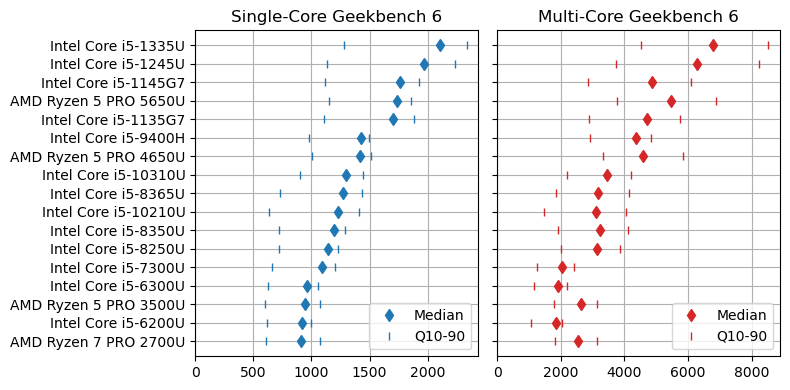

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(8,4))

col_single = 'tab:blue'
ax1.set(title='Single-Core Geekbench 6')
ax1.plot(all_stats['Single q50'], all_stats.index, 'd', color=col_single, label='Median')
ax1.plot(all_stats['Single q90'], all_stats.index, '|', color=col_single, label='Q10-90')
ax1.plot(all_stats['Single q10'], all_stats.index, '|', color=col_single)

col_multi = 'tab:red'
ax2.set(title='Multi-Core Geekbench 6')
ax2.plot(all_stats['Multi q50'], all_stats.index, 'd', color=col_multi, label='Median')
ax2.plot(all_stats['Multi q90'], all_stats.index, '|', color=col_multi, label='Q10-90')
ax2.plot(all_stats['Multi q10'], all_stats.index, '|', color=col_multi)

for axi in (ax1, ax2):
    axi.grid(True)
    axi.legend(loc='lower right')
    axi.set_xlim(xmin=0)

fig.tight_layout()
fig.savefig(f'CPUs_GB6_stats_sort-{sortby}.png', dpi=300)